In [1]:
import numpy as np
import os
import math
from dxfwrite import DXFEngine as dxf
from scipy.spatial import Delaunay , delaunay_plot_2d
from matplotlib import collections as mc
import pylab as pl
import copy
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PolyCollection
import time

#################----> Creating results folder

In [2]:
def modeV(v):
#    print('modeV( v F // V**0.5 G')
    V = 0.0
    for vi in v:
        V = V + np.float32(vi)**2
    return V**(0.5)

def proj_vect(v,w):
    """ proj_vect(v,w) give the projection of vector v over w"""
    W = modeV(w)**2
    sc = 0.0
    for i in range(len(v)):
        sc = sc + float(v[i])*np.float32(w[i])
    proj = np.zeros(len(v))
    for i in range(len(v)):
        proj[i] = np.float32((sc/W))*w[i]
    return  proj

def intersect_lines(m1,n1,m2,n2):
    x = (n2-n1)/(m1-m2)
    return np.array([x, 0.0, x*m1+n1])
def check_out_bound( point, sizeXYZ, equal = True):
    B = []
    if equal:
        for i in [0,2]:
            B.append(point[i] <= 0.0)
            B.append(point[i] >= sizeXYZ[0,i])
    else:
        for i in [0,2]:
            B.append(point[i] < 0.0)
            B.append(point[i] > sizeXYZ[0,i])
    return B
def create_points_t(c0,c1,c2, T, sizeXYZ, N):
    Nold, index, newp = N, [], []
    np.seterr(divide='ignore')
    t_v = np.array([[(c1[2]-c0[2]),0.0,-(c1[0]-c0[0])], 
                     [-(c1[2]-c0[2]),0.0,(c1[0]-c0[0])]])
    t_v = c1 + t_v*(T/(2.0*modeV(t_v[0])))  # point left and point right l01

    t_vt = np.array([[(c2[2]-c1[2]),0.0,-(c2[0]-c1[0])], 
                     [-(c2[2]-c1[2]),0.0,(c2[0]-c1[0])]])
    t_vt = c1 + t_vt*(T/(2.0*modeV(t_vt[0]))) #  point left and point right l12   
    deltaX = [(c1[0]-c0[0]) == 0.0 , (c2[0]-c1[0]) == 0.0]
    index = np.ones((2,2),dtype=int)*-1
    if all(deltaX):
        point = np.array([c1 + np.sign((c1[2]-c0[2]))*np.array([T/2,0.0,0.0]), c1+ np.sign(-(c1[2]-c0[2]))*np.array([T/2,0.0,0.0])])
        i = -1
        for p in point:
            i = i+1
            if not(any(check_out_bound(p, sizeXYZ, False))):
                index[:,i]=[N,N]
                newp.append(p)
                N = N + 1
    elif any(deltaX):
        for i in range(len(t_v)):
            if deltaX[0]:
                t = [t_v[i], t_vt[i]]
                mm = np.array([(c2[2]-c1[2])/(c2[0]-c1[0])])
                point = np.array(intersect_lines(mm[0], -t[1][0]*mm[0]+t[1][2], mm[0]-1, (t[0][0]-t[1][0]*mm[0]+t[1][2])))
                if not(any(check_out_bound(point, sizeXYZ, False))):
                    index[:,i]=[N,N]
                    newp.append(point)
                    N = N + 1
                else:
                    point = []
                    point.append(intersect_lines(mm[0], -t[1][0]*mm[0]+t[1][2], mm[0]-1, (c1[0]-t[1][0]*mm[0]+t[1][2])))
                    point.append(intersect_lines(mm[0], -t[1][0]*mm[0]+t[1][2], 0.0, c1[2]))
                    for p in point:
                        if not(any(check_out_bound(p, sizeXYZ, equal= False))):
                            index[1,i] = N
                            newp.append(p)
                            N = N+1
            elif deltaX[1]:
                t = [t_v[i], t_vt[i]]
                mm = np.array([(c1[2]-c0[2])/(c2[0]-c0[0])])
                point = np.array(intersect_lines(mm[0], -t[0][0]*mm[0]+t[0][2], mm[0]-1, (t[1][0]-t[0][0]*mm[0]+t[0][2])))
                if not(any(check_out_bound(point, sizeXYZ, False))):
                    index[:,i]=[N,N]
                    newp.append(point)
                    N = N + 1
                else:
                    point = [intersect_lines(mm[0], -t[0][0]*mm[0]+t[0][2], mm[0]-1, (c1[0]-t[0][0]*mm[0]+t[0][2])),
                            intersect_lines(mm[0], -t[0][0]*mm[0]+t[0][2], 0.0, c1[2])]
                    for p in point:
                        if not(any(check_out_bound(p, sizeXYZ, equal= False))):
                            index[0,i] = N
                            newp.append(p)
                            N = N+1
    elif (np.array([t_v[i] == t_vt[i] for i in range(len(t_v))]).all()):
        if ((c1[2]-c0[2]) == 0.0):
            point = np.array([c1 + np.sign((c1[0]-c0[0]))*np.array([0.0,0.0,-T/2]), c1+ np.sign(-(c1[0]-c0[0]))*np.array([0.0,0.0,-T/2])])
            i = -1
            for p in point:
                i = i+1
                if not(any(check_out_bound(p, sizeXYZ, False))):
                    index[:,i]=[N,N]
                    newp.append(p)
                    N = N + 1
        else:
            mm = (c1[2]-c0[2])/(c1[0]-c0[0])
            for i in range(len(t_v)):
                point = t_v[i]
                t = t_v[i]
                if not(any(check_out_bound(point, sizeXYZ, False))):
                    index[:,i]=[N,N]
                    newp.append(point)
                    N = N + 1
                else:
                    point = []
                    try:
                        point.append(intersect_lines(mm, -t[0]*mm+t[2], mm-1, (c1[0]-t[0]*mm+t[2])))
                    except:
                        pass
                    try:
                        point.append(intersect_lines(mm, -t[0]*mm+t[2], 0.0, c1[2]))
                    except:
                        pass
                    for p in point:
                        if not(any(check_out_bound(p, sizeXYZ, equal= False))):
                            index[:,i]= [N,N]
                            newp.append(p)
                            N = N + 1

    else:
        mm = np.array([(c1[2]-c0[2])/(c1[0]-c0[0]), (c2[2]-c1[2])/(c2[0]-c1[0])])
        beta = (np.sum(mm))/2
        for i in range(len(t_v)):
            t = [t_v[i], t_vt[i]]
            point = np.array(intersect_lines(mm[0], -t[0][0]*mm[0]+t[0][2], mm[1], -t[1][0]*mm[1]+t[1][2]))
            if not(any(check_out_bound(point, sizeXYZ, False))):
                index[:,i]=[N,N]
                newp.append(point)
                N = N + 1
            elif mm[0] == mm[1]:
                point = []
                try:
                    point.append(intersect_lines(mm[0], -t[0][0]*mm[0]+t[0][2], mm[0]-1, (c1[0]-t[0][0]*mm[0]+t[0][2])))
                except:
                    pass
                try:
                    point.append(intersect_lines(mm[0], -t[0][0]*mm[0]+t[0][2], 0.0, c1[2]))
                except:
                    pass
                for p in point:
                    if not(any(check_out_bound(p, sizeXYZ, equal= False))):
                        index[:,i]= [N,N]
                        newp.append(p)
                        N = N + 1
            else:
                for j in [0,1]:
                    point = []
                    try:
                        point.append(intersect_lines(mm[j], -t[j][0]*mm[j]+t[j][2], mm[j]-1, (c1[0]-t[j][0]*mm[j]+t[j][2])))
                    except:
                        pass
                    try:
                        point.append(intersect_lines(mm[j], -t[j][0]*mm[j]+t[j][2], 0.0, c1[2]))
                    except:
                        pass
                    for p in point:
                        if not(any(check_out_bound(p, sizeXYZ, equal= False))):
                            if mm[0] == mm[1]:
                                index[:,i]= [N,N]
                                j = 2
                            else:
                                index[j,i]= N
                            newp.append(p)
                            N = N + 1   
    return newp, index, N, Nold
        
def gen_t_faces(index, edges, faces, N, Nold, i = 1):
    edges.extend([[a] for a in range(Nold, N)])
    face =  [[i-1],[i-1]]
    #    facep = [[i-1],[i-1]]
    for irow in [index[1],index[2]]:
        for ii in [0,1]:
            if irow[ii] != -1:
                face[ii].append(irow[ii])
    for f in face:
        ff = f[:]
        if len(f) > 2:
            if f[1] not in edges[f[0]]:
                edges[f[0]].append(f[1])
            edges[f[1]].append(f[2])

            if f[2] not in edges[i]:
                edges[i].append(f[2])
            ff.append(i)
            faces.append(ff)   
    index = index[-2:]
    return index, edges, faces
 
def gen_thicknes_data(N, coord, t, sizeXYZ, edges):
#    print('gen_t_coord(N, coord, t, sizeXYZ, edges) F // coco, edges, faces, N G')
    coco = []
    ind = []
    faces= []
    if (0 in edges[np.shape(coord)[0]-1]) or (int(np.shape(coord)[0]-1) in edges[0]):
        c, index, N, Nold = create_points_t(coord[-1],coord[0],coord[1], t, sizeXYZ, N)
        lasti = index[:]
    else:
        c, index, N, Nold = create_points_t(2*coord[0]-coord[1],coord[0],coord[1], t, sizeXYZ, N)
    coco.extend(c)
    ind.extend(index)
    edges.extend([[a] for a in range(Nold, N)])
    for i in range(1,len(coord)-1):
        c, index, N, Nold = create_points_t(coord[i-1],coord[i],coord[i+1], t, sizeXYZ, N)
        coco.extend(c)
        ind.extend(index)
        ind, edges, faces = gen_t_faces(ind, edges, faces, N, Nold, i)
    if (0 in edges[np.shape(coord)[0]-1]) or (int(np.shape(coord)[0]-1) in edges[0]):
        c, index, N, Nold = create_points_t(coord[i],coord[i+1], coord[0], t, sizeXYZ, N)      
        coco.extend(c)
        ind.extend(index)
        ind, edges, faces = gen_t_faces(ind, edges, faces, N, Nold, i+1)
        ind.extend(lasti)
        ind, edges, faces = gen_t_faces(ind, edges, faces, N, Nold, i+2)
    else:
        c, index, N, Nold = create_points_t(coord[i],coord[i+1], 2*coord[i+1]-coord[i], t, sizeXYZ, N)
        coco.extend(c)
        ind.extend(index)
        ind, edges, faces = gen_t_faces(ind, edges, faces, N, Nold, i+1)
    coord = np.concatenate((coord, np.reshape(np.asarray(coco),(len(coco),3))))
    return coord, edges, faces, N 
        
def gen_thickness_data(self):
    N, coord, t, sizeXYZ, edges = self.N(), self.nodes, self.t, self.sizeXYZ, self.edges
    coco, ind, faces= [[],[],[]]
    if (0 in edges[np.shape(coord)[0]-1]) or (int(np.shape(coord)[0]-1) in edges[0]):
        c, index, N, Nold = create_points_t(coord[-1],coord[0],coord[1], t, sizeXYZ, N)
        lasti = index[:]
    else:
        c, index, N, Nold = create_points_t(2*coord[0]-coord[1],coord[0],coord[1], t, sizeXYZ, N)
    coco.extend(c)
    ind.extend(index)
    edges.extend([[a] for a in range(Nold, N)])
    for i in range(1,len(coord)-1):
        c, index, N, Nold = create_points_t(coord[i-1],coord[i],coord[i+1], t, sizeXYZ, N)
        coco.extend(c)
        ind.extend(index)
        ind, edges, faces = gen_t_faces(ind, edges, faces, N, Nold, i)
    if (0 in edges[np.shape(coord)[0]-1]) or (int(np.shape(coord)[0]-1) in edges[0]):
        c, index, N, Nold = create_points_t(coord[i],coord[i+1], coord[0], t, sizeXYZ, N)      
        coco.extend(c)
        ind.extend(index)
        ind, edges, faces = gen_t_faces(ind, edges, faces, N, Nold, i+1)
        ind.extend(lasti)
        ind, edges, faces = gen_t_faces(ind, edges, faces, N, Nold, i+2)
        faces[-1][-1] = 0
        edges = edges[:-1]
    else:
        c, index, N, Nold = create_points_t(coord[i],coord[i+1], 2*coord[i+1]-coord[i], t, sizeXYZ, N)
        coco.extend(c)
        ind.extend(index)
        ind, edges, faces = gen_t_faces(ind, edges, faces, N, Nold, i+1)

    self.nodes = np.concatenate((coord, np.reshape(np.asarray(coco),(len(coco),3))))
    self.edges, self.faces = edges, faces

In [160]:
class RVE:
    def __init__(self, eletypeID = None, sizeXYZ=[1.0,0.0,1.0], t = 0.0):
        self.sizeXYZ = np.reshape(np.asarray(sizeXYZ), (1,3))
        self.bound_node = {}
        if eletypeID != None:
            self._eletype = self._eletype(eletypeID)
        else: #Define your element
            self.eletype = eletypeID
            self.nodes = None
            self.edges = None
            self.faces = None
            self.sym = None
            self.dim = None
        self._get_input()
        self.t = t
        if t !=0.0:
            self._get_faces()
    def N(self):
        return len(self.nodes)
    def _eletype(self, eletypeID):
        self.eletypeID = eletypeID
        self.sym = []
        self.dim = [0,2]
        def e0(self):
            self.nodes = np.array([[0,0,0],[1,0,0]], dtype="float")
            self.edges = np.array([[0,1]])
            self.dim = [0]
        def e1(self):
            self.nodes = np.array([[1,0],[0,0],[1,1],[0,1]], dtype="float")
            self.edges = np.array([[0,1],[1,2],[2,3]])
            self.sym = [0,2]    
        def e3(self):
            self.nodes = np.array([[0,0],[0,0.5],[1,1]], dtype="float")
            self.edges = np.array([[0,1],[1,2]])
            self.sym = [0,2]
        def e4(self):
            self.nodes = np.array([[0,0],[0,1],[1,1],[1,0]], dtype="float")
            self.edges = np.array([[0,1],[1,2],[2,3],[3,0]])
            self.faces = np.array([[]])
        def e5(self): # cube
            self.nodes = np.array([[0,0,0],[1,0,0],[0,1,0],[1,1,0],[0,0,1],[1,0,1],[0,1,1],[1,1,1]], dtype="float")
            self.edges = np.array([[0,1],[0,2],[2,3],[1,3],[0,4],[1,5],[2,6],[3,7],[4,5],[4,6],[5,7],[6,7]])
            self.faces = np.array([[0,1,3,2],[4,5,7,6],[0,1,5,4],[0,2,6,4],[1,3,7,5],[2,3,7,6]])
            self.dim = (0,1,2)
        def e6(self): # X shape
            self.nodes = np.array([[0,0,0],[1,0,0],[0,1,0],[1,1,0],[0,0,1],[1,0,1],[0,1,1],[1,1,1]], dtype="float")
            self.edges = np.array([[0,7],[1,6],[2,5],[3,4]])
            self.faces = np.array([[]])
            self.dim = (0,1,2)
        def e7(self): # hexa-tetrahedrom
            self.nodes = np.array([[0,0,0],[1,0,0],[0,1,0],[1,1,0],[0,0,1],[1,0,1],[0,1,1],[1,1,1]], dtype="float")
            self.edges = np.array([[0,1],[0,2],[0,3],[2,3],[1,3],[2,7],[1,7],[1,4],[2,4],[4,6],[4,5],[5,7],[6,7],[4,7]])
            self.faces = np.array([[0,2,3],[0,1,3],[4,6,7],[4,5,7],[2,4,7],[1,4,7]])
            self.sym = [0,1,2]
            self.dim = (0,1,2)
        def e8(self): # octet-truss
            self.nodes = np.array([[0,0,0],[1,1,0],[1,0,1],[0,1,1]], dtype="float")
            self.edges = np.array([[0,1],[0,2],[0,3],[2,3],[1,2],[1,3]])
            self.faces = np.array([[]])
            self.sym = [0,1,2]
            self.dim = (0,1,2)
        #    print(' get_basic_elem( e F) // nodes, edges, faces, sym, dim G')
        try:
            eval('e'+str(self.eletypeID)+'(self)')  
        except:
            raise NameError('Element type %s is not defined.' %self.eletypeID)
       
    def _get_input(self):
        if type(self.sizeXYZ)!= np.array:
            self.sizeXYZ = np.asmatrix(self.sizeXYZ)
        # Amount of nodes
        self._scale = np.divide(self.sizeXYZ[:,self.dim],np.max(self.nodes, axis=0))
        self.nodes = np.multiply(self.nodes,self._scale)
        # Adding missing dimension in case of node coordinates given in 2D
        if np.shape(self.nodes)[1] != 3:
            self.nodes = np.array([self.nodes[:,0],np.zeros([np.shape(self.nodes)[0],1]),self.nodes[:,1]]).T[0]
            self._scale = np.array([self._scale[:,0],np.zeros([np.shape(self._scale)[0],1]),self._scale[:,1]]).T[0]
        T_edges = [[a] for a in range(self.N())]
        for i,j in self.edges:
            if j not in T_edges[i]:
                T_edges[i].append(j)
        self.edges = T_edges
    #    print('get_input(coord, edges, faces, sizeXYZ, dim F) // coord, T_edges, N, scale G')
        assert np.sum(self.sizeXYZ!=0)==len(self.dim), ValueError('Element cell size (RVE.sizeXYZ) and element dimensions (self.dim) do not match: sizeXYZ=%s dim=%s'% (self.sizeXYZ, self.dim))
    
    def _get_faces(self):
        Nn = self.N()
        gen_thickness_data(self)
        self.bound_node = set(range(Nn, self.N() ))
        
        
    def printDATA(self):
        for x in ['nodes', 'edges', 'faces']:
            try:
                print(str(x)+': {}\n'.format(eval('self.'+x)))
            except:
                pass
    def show(self):
        
        def show2F(self):
            pass
        def show2T(self):
            verts = [self.nodes[f][:,self.dim] for f in self.faces]
            print(verts)
            fig, ax = plt.subplots()
            # Make the collection and add it to the plot.
            coll = PolyCollection(verts, hatch ='/',linestyle=':')
            ax.add_collection(coll)
            ax.autoscale_view()
            plt.show()   
        def show3F(self):
            pass
        eval('show'+str(len(self.dim))+str(bool(self.t))[0]+'(self)')


In [161]:
p = RVE(eletypeID = 1, t=0.0)
p.printDATA()
p.show()


nodes: [[1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 1.]]

edges: [[0, 1], [1, 2], [2, 3], [3]]



In [147]:
def gen_mesh(self, meshSize):
    def do_trimming(grid, bound_node):
    #    print('do_trimming(grid, bound_node F) // gridd G')
        gridd=[]
        for facet in grid:
            if not(all(f in bound_node for f in facet)):
                gridd.append(facet)
            else:
                pass
        gridd = np.asanyarray(gridd)
        return gridd
    N = self.N()
    minsize, maxsize = [float(m) for m in meshSize]
    old_edges = copy.deepcopy(self.edges)
    newc = []
    k =-1
    self.edges = [[a] for a in range(N)]
    for edge in old_edges:
        for no in edge[1:]:
            nedges = []
            ni=edge[0]
            vect = self.nodes[no]-self.nodes[ni]
            dist = np.linalg.norm(vect)
            div = 1
            while ((dist>maxsize) and ((dist/(div+1)>=minsize) and (dist/(div)>maxsize))):
                div = div + 1
            newcoord = self.nodes[ni]
            # Add new edges and new nodes to the data
            for i in range(1,div):
                k = k + 1
                newcoord = newcoord + vect*(1./div)
                newc.append(newcoord)
                nedges.append(k+N)
                self.edges.append([k+N])
            if len(self.bound_node) !=0:
                if (ni in self.bound_node) and (no in self.bound_node):
                    # Add new bound nodes to the bound node set
                    self.bound_node = self.bound_node.union(set(nedges))
            if len(nedges) == 0:
                self.edges[ni].append(no)
            if len(nedges) != 0:
                self.edges[ni].append(nedges[0])
                self.edges[no].append(nedges[-1])
            if len(nedges)>=2:
                for nn in nedges[0:-1]:
                    self.edges[nn].append(nn+1)  
    # Add new nodes to the node array
    self.nodes = np.concatenate((self.nodes, np.reshape(newc,(len(newc),3))))
    # TRIANGULATE faces if needed
    if (np.sum(self.faces) != 0):
        triang = Delaunay(self.nodes[:,[0,2]])
        self.faces = do_trimming(triang.simplices, self.bound_node)
#            delaunay_plot_2d(triang)
        plt.figure()
        plt.axis('equal')
        plt.axis('off')
        plt.triplot(self.nodes[:,0], self.nodes[:,2], self.faces)
        plt.show()
        plt.savefig('tria' + '.pdf')
        


In [166]:
print(R.eletypeID)

1


nodes: [[1.         0.         0.        ]
 [0.         0.         0.        ]
 [1.         0.         1.        ]
 [0.         0.         1.        ]
 [1.         0.         0.1       ]
 [0.24142136 0.         0.1       ]
 [0.         0.         0.14142136]
 [1.         0.         0.85857864]
 [0.75857864 0.         0.9       ]
 [0.         0.         0.9       ]]

edges: [[0, 1, 4], [1, 2, 5, 6], [2, 3, 7, 8], [3, 9], [4, 5], [5, 7], [6, 8], [7], [8, 9], [9]]

faces: [[0, 4, 5, 1], [1, 5, 7, 2], [1, 6, 8, 2], [2, 8, 9, 3]]



c:\users\jccap\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


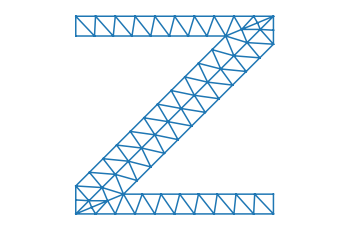

<Figure size 432x288 with 0 Axes>

In [165]:
p = RVE(1,t=0.2)
R = RVE(1,t=0)
p.printDATA()
gen_mesh(p, meshSize = [0.05,0.1])


In [149]:
def get_unique_sorted(column_matrix):
    l_cm = len(column_matrix)
    column_matrix=np.reshape(column_matrix,( l_cm,1))
    index_sort = np.argsort(column_matrix,axis = 0)
    unique_values, uni_sort_ind = np.unique(np.reshape(column_matrix[index_sort],(l_cm,1)),axis=0,return_inverse = True)
    c_mat_us = uni_sort_ind[np.argsort(index_sort,axis = 0)]
    return unique_values, c_mat_us

def check_Dim_Mult(coord, sizeDim):
    delta, idim = get_unique_sorted(coord)
    if delta[-1] != 0:
        coord = np.matrix(coord*sizeDim/float(delta[-1]))
        delta = float(sizeDim/delta[-1])*delta
    n_L = int(np.shape(delta)[0])
    return coord, delta, idim, n_L
def check_dimensions(self):
    for dimension in [0,1,2]:
        if dimension not in self.RVE.dim:
            self.n_G[dimension] = 1
def do_pregrid(self):
#    print('do_pregrid( nodes, sizeXYZ F) // n_L, ii, self.delmax, delta G')
# Generating data to prepare the mesh
    ii = []
    n_L = []
    delta = []
    self.delmax = []
    for d in [0,1,2]:
        ## AQUIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
        self.RVE.nodes[:,d], delt, idim, n_ = check_Dim_Mult(self.RVE.nodes[:,d], self.RVE.sizeXYZ[0,d])
        delta.append(delt)
        self.delmax.append(float(max(delt)))
        ii.append(idim)
        n_L.append(n_)
    self.delmax = np.array(self.delmax)
    del(delt, n_, idim)
    self.n_L, self.ii, self.delmax, self.delta = n_L, ii, self.delmax, delta

def do_translate(tobetranslated, dictionary):

    assert (type(tobetranslated) == list), 'Please insert a list object'
    translation=[]
    word_o = -1
    for word in tobetranslated:
        if word == word_o:
            pass
        else:
            try:
                translation.append(dictionary[word])
            except:
                pass
        word_o = word
    return translation


In [150]:


def do_shapeME(self, coord, ii):
    def shape_(self,r):
        return np.zeros([1,3])
       
    def shape_random(self,r, coef_rand =0.625):
        return np.random.uniform(-self.delmax/coef_rand,self.delmax/self.coef_rand,(1,3))
           
    def shape_progressive(self,r):
        try:
            return np.array([float((self.I[0]+ii[r,0])**2), float((self.I[1]+ii[r,1])**2),  float((self.I[2]+ii[r,2])**2)])
        except:
            try:
                return np.array([float((self.I[0]+ii[r,0])**2), 0.0,  float((self.I[2]+ii[r,2])**2)])
            except:
                return np.array([float((self.I[0]+ii[r,0])**2),0.0,0.0])
           
    def shape_flower(self,r, a = 5.0, b = 0.3):
        self.TOT_angleX, self.TOT_angleY = 5*math.pi, 1.0
        xt = (a+z)*math.cos(self.TOT_angleX*self._fract_angleX)*math.sin(self.TOT_angleY*self._fract_angleY)-x
        yt = (a+z)*math.sin(self.TOT_angleX*self._fract_angleX)*math.sin(self.TOT_angleY*self._fract_angleY)-y
        zt = (a+z)*(math.cos(self.TOT_angleY*self._fract_angleY)+math.log(math.tan(0.5*self.TOT_angleY*self._fract_angleY)))+b*self.TOT_angleX*self._fract_angleX-z
        return np.array([xt,yt,zt])
           
    def shape_ring(self,r, R = 25.0, Ri = 3.0):
        self.TOT_angleX, self.TOT_angleY = 2.0*math.pi, 2.0*math.pi
        xt = math.cos(self.TOT_angleX*self._fract_angleX)*(R+(Ri+z)*math.cos(self.TOT_angleY*self._fract_angleY))-x
        yt = math.sin(self.TOT_angleX*self._fract_angleX)*(R+(Ri+z)*math.cos(self.TOT_angleY*self._fract_angleY))-y
        zt = (Ri+z)*math.sin(self.TOT_angleY*self._fract_angleY)-z
        return np.array([xt,yt,zt])
           
    def shape_galaxy(self,r,aa= 3, a=1):
        self.TOT_angleX, self.TOT_angleY = 2*math.pi,4*math.pi
        xt = (a+z)*(aa+math.cos(self.TOT_angleY*self._fract_angleY/2)*math.sin(self.TOT_angleX*
                self._fract_angleX)-math.sin(self.TOT_angleY*self._fract_angleY/2)*math.sin(2*
                                     self.TOT_angleX*self._fract_angleX))*math.cos(self.TOT_angleY*self._fract_angleY) - x
        yt = (a+z)*(aa+math.cos(self.TOT_angleY*self._fract_angleY/2)*math.sin(self.TOT_angleX*
                self._fract_angleX)-math.sin(self.TOT_angleY*self._fract_angleY/2)*math.sin(2*
                                     self.TOT_angleX*self._fract_angleX))*math.sin(self.TOT_angleY*self._fract_angleY) -y
        zt = (a+z)*(math.sin(self.TOT_angleY*self._fract_angleY/2)*math.sin(self.TOT_angleX*
                     self._fract_angleX)+math.cos(self.TOT_angleY*self._fract_angleY/2)*
                     math.sin(2*self.TOT_angleX*self._fract_angleX)) -  z
        return np.array([xt,yt,zt])
           
    def shape_triplefris(self,r):
        self.TOT_angleX, self.TOT_angleY = math.pi, 3*math.pi
        xt = (1+z)*((math.cos(self.TOT_angleX*self._fract_angleX)*((1/3)*math.sqrt(2.0)*
                      math.cos(self.TOT_angleX*self._fract_angleX)*math.cos(2*self.TOT_angleY*self._fract_angleY) + (2/3)*
                      math.sin(self.TOT_angleX*self._fract_angleX)*math.cos(self.TOT_angleY*self._fract_angleY)))/(1 - math.sqrt(2.0)*
                      math.sin(self.TOT_angleX*self._fract_angleX)*math.cos(self.TOT_angleX*self._fract_angleX)*
                      math.sin(3*self.TOT_angleY*self._fract_angleY))) - x
        yt = (1+z)*((math.cos(self.TOT_angleX*self._fract_angleX)*((1/3)*math.sqrt(2.0)*math.cos(self.TOT_angleX*
                      self._fract_angleX)*math.sin(2*self.TOT_angleY*self._fract_angleY) -(2/3)*
                      math.sin(self.TOT_angleX*self._fract_angleX)*math.cos(self.TOT_angleY*self._fract_angleY)))/ (1 - math.sqrt(2.0)*
                      math.sin(self.TOT_angleX*self._fract_angleX)*math.cos(self.TOT_angleX*self._fract_angleX)*
                      math.sin(3*self.TOT_angleY*self._fract_angleY))) - y
        zt = (1+z)*((math.cos(self.TOT_angleX*self._fract_angleX)*math.cos(self.TOT_angleX*self._fract_angleX))/(1 - math.sqrt(2.0)*
              math.sin(self.TOT_angleX*self._fract_angleX)*math.cos(self.TOT_angleX*self._fract_angleX)*math.sin(3*
                      self.TOT_angleY*self._fract_angleY)) - 1) - z
        return np.array([xt,yt,zt])
           
    def shape_quadratic(self,r):
        xt = -0.5*x
        yt = 0
        zt = (0.005*(x-5)**2)
        return np.array([xt,yt,zt])
           
    def shape_shell(self,r):
        xt = 0
        yt = 0
        zt = (0.05*(x-self.delmax[0]*(self.n_G[0]*(self.n_L[0]-1))/2.0)**2) + (0.05*(y-self.delmax[1]*(self.n_G[1]*(self.n_L[1]-1))/2.0)**2)  
        return np.array([xt,yt,zt])
    
    def shape_circle(self,r, Ri = 3.0):
        self.TOT_angleX = 2*math.pi
        return shape_cylinder(self,r)
    
    def shape_cylinder(self,r,Ri = 3.0): 
        
        self.TOT_angleX = 2*math.pi
        xt = (z+Ri)*math.cos(self._fract_angleX*self.TOT_angleX)-x
        yt = 0
        zt = (z+Ri)*math.sin(self._fract_angleX*self.TOT_angleX)-z
        return np.array([xt,yt,zt])
               
    def shape_catenoid(self,r,Ri = 5.0):
        self.TOT_angleX, self.TOT_angleY = 2*math.pi, math.pi
        xt = (z+Ri)*math.cos(self.TOT_angleX*self._fract_angleX-math.pi)*math.cosh(self.TOT_angleY*self._fract_angleY/Ri)-x
        yt = (z+Ri)*math.sin(self.TOT_angleX*self._fract_angleX-math.pi)*math.cosh(self.TOT_angleY*self._fract_angleY/Ri)-y
        zt = (self.TOT_angleY*self._fract_angleY)-z
        return np.array([xt,yt,zt])
#            
    def shape_sphere(self, r, Ri=3.0):
        self.TOT_angleX, self.TOT_angleY = 2*math.pi, math.pi
        xt = (z+Ri)*math.cos(self.TOT_angleX*self._fract_angleX)*math.sin(self.TOT_angleY*self._fract_angleY)-x
        yt = (z+Ri)*math.cos(self.TOT_angleY*self._fract_angleY)-y
        zt = (z+Ri)*math.sin(self.TOT_angleX*self._fract_angleX)*math.sin(self.TOT_angleY*self._fract_angleY)-z
        return np.array([xt,yt,zt])
           
    def shape_NURBS(self,r):
        xt = 0
        yt = 0
        zt = (0.005*(x-self.delmax[0]*(self.n_G[0]*(self.n_L[0]-1))/2.0)*(y-self.delmax[1]*(self.n_G[1]*(self.n_L[1]-1))/2.0))**3
        +(0.005*(x-self.delmax[0]*(self.n_G[0]*(self.n_L[0]-1))/2.0)*(y-self.delmax[1]*(self.n_G[1]*(self.n_L[1]-1))/2.0))**2
        +(0.005*(x-self.delmax[0]*(self.n_G[0]*(self.n_L[0]-1))/2.0)*(y-self.delmax[1]*(self.n_G[1]*(self.n_L[1]-1))/2.0))
        return np.array([xt,yt,zt])
   
    r = -1
 
    for x,y,z in coord:
        r = r+1
        self._fract_angleX = float((float(self.I[0]*(self.n_L[0]-1)+ii[r,0]))/(self.n_G[0]*(self.n_L[0]-1)))
        if self.n_L[1] != 1: self._fract_angleY = float((float(self.I[1]*(self.n_L[1]-1)+ii[r,1]))/(self.n_G[1]*(self.n_L[1]-1)))
        self.mesh[self.num_r[0,r]] = coord[r] + np.around(eval('shape_'+str(self.shape)+'(self,r)'),12)
        flag = False
        for n in self.RVE.dim:
            if (self.I[n] == 0)&(ii[r,n] == 0):
                for symmetric in self.bound[n]:
                    if np.all(np.power(self.mesh[self.num_r[0,r]]-self.mesh[symmetric,:],2)<1e-6)&(flag==False):
                        self.num_r[0,r] = symmetric
                        flag = True
                if (flag==False):
                    self.Boundary[2*n].add(self.num_r[0,r])
                    if self.TOT_angleX !=None: self.bound[n].append(self.num_r[0,r])
            if (self.I[n] == (self.n_G[n]-1))&(ii[r,n] == self.n_L[n]-1)&(flag==False):
                for symmetric in reversed(self.bound[n]):
                    if np.all(np.power(self.mesh[self.num_r[0,r]]-self.mesh[symmetric,:],2)<1e-6)&(flag==False):
                        self.num_r[0,r] = symmetric
                        flag = True
                if flag == False:
#                             print(4,r)
                    self.Boundary[2*n+1].add(self.num_r[0,r])
                    if self.TOT_angleY !=None: self.bound[n].append(self.num_r[0,r])


In [302]:
class LatticeStructure:
    def __init__(self, _RVE, n_G=[1,1,1], shape=''):
        assert type(_RVE) == RVE, 'Please enter an RVE object'
        self.n_G = n_G
        self.shape = shape
        self.RVE = _RVE

    def gen_nodegrid(self):  
        check_dimensions(self)
        do_pregrid(self)
        N = self.RVE.N()
        nlayer = ((self.n_L[0]-1)*self.n_G[0]+1)*(self.n_L[2]-1) #each row of elements(X direction)
        nplane = ((self.n_L[0]-1)*self.n_G[0]+1)*((self.n_L[2]-1)*self.n_G[2]+1) #each plane XZ of elements
        # Initialize mesh: matrix with the node coordinates by rows.
        self.mesh = np.zeros([nplane*((self.n_L[1]-1)*self.n_G[1]+1),3]) # Coordinates of the grid are ordered WE & SN
        # Initialize index: boolean vector to determine the real node rows in the mesh matrix.
        self.index = np.zeros(nplane*((self.n_L[1]-1)*self.n_G[1]+1))
        # Initialize num: Transformation matrix from global to local nodes.
        # Each row corresponds to one element.
        # Elements are ordered from WE & SN
        self.num = np.array(np.zeros([self.n_G[0]*self.n_G[1]*self.n_G[2],N]))
        # Initialize Boundary: List of the list of boundary nodes of the basic element.
        self.Boundary = [set(),set(),set(),set(),set(),set()] # Boundaries[min(x), max(x), min(y), max(y), min(z), max(z)]
        self.bound, self.TOT_angleX, self.TOT_angleY= [[],[],[]], None, None
        p = -1
        if  self.RVE.sym !=-1:
            msize = [1,1,1]
            for rep in  self.RVE.sym:
                msize[rep] = 2
            msize.append(N)
            ind_elem_GS = np.zeros(msize)
            msize.append(3)
            self.iiS = np.zeros(msize)
            coordS = np.zeros(msize)
        for i in range(msize[0]):
            for j in range(msize[1]):
                for k in range(msize[2]):
                    indbol = np.array([bool(i),bool(j),bool(k)])
                    coords = np.array(self.RVE.nodes)
                    coords[:,indbol] = np.reshape(np.repeat([self.delmax[indbol]],N,axis=0),(N,sum(indbol))) - self.RVE.nodes[:,indbol]
                    coordS[i,j,k] = coords
                    iis = np.array(self.ii)
                    iis = [abs(max(self.ii[0])*indbol[0]-self.ii[0]),abs(max(self.ii[1])*indbol[1]-self.ii[1]),abs(max(self.ii[2])*indbol[2]-self.ii[2])]
                    ind_elem_Gs = (iis[0] + iis[1]*nplane + iis[2]*nlayer/(self.n_L[2]-1))
                    self.iiS[i,j,k] = np.reshape(iis, np.shape(iis)[:-1]).T
                    ind_elem_GS[i,j,k] = np.reshape(ind_elem_Gs,(len(ind_elem_Gs)))
        del(coords,ind_elem_Gs, iis, indbol)
        ind_elem_GS = ind_elem_GS.astype(int)
        p = -1
        self.bound[1]=[]
        for j in range(self.n_G[1]):
            if 1 in  self.RVE.sym:
                jT = j % 2
            else:
                jT = 0
            self.bound[2]=[]
            for k in range(self.n_G[2]):
                if 2 in self.RVE.sym:
                    kT = k % 2
                else:
                    kT = 0
                self.bound[0]=[]
                for i in range(self.n_G[0]):
                    if 0 in  self.RVE.sym:
                        iT = i % 2
                    else:
                        iT = 0
                    p = p + 1
                    self.I = [i,j,k]
                    self.num_r = np.reshape(ind_elem_GS[iT,jT,kT] + i*(self.n_L[0]-1) + k*nlayer+ j*nplane,(1,N))
                    [dx,dy,dz] = [np.float32(self.delmax[0]*i), np.float32(self.delmax[1]*j), np.float32(self.delmax[2]*k)]
                    do_shapeME(self, coordS[iT,jT,kT]+[dx,dy,dz],self.iiS[iT,jT,kT])
                    self.num[p,:] = self.num_r
                    self.index[self.num_r] = np.ones([len(self.num_r),1])        
        self.index = self.index.astype("bool")
        self.num = self.num.astype("int")
        self.mesh = self.mesh[self.index].astype("float32") #Take only the nodes of interest from the rectangular grid
        # Hash from index imaginary rectangular grid to node grid.
        # The row number is the global node number and the value is the
        # correspondant node to the imaginary rectangular grid.
        self.index = np.arange(0,len(self.index),1)[self.index]
        self.ind_hash, k = {}, -1
        for i in self.index:
            k = k + 1
            self.ind_hash[i] = k
        self.Boundary = [do_translate(list(b),  self.ind_hash) for b in self.Boundary]

    def gen_edges(self):
        # Initializing global adjecency list
        self.edges =  [[a] for a in range(len(self.ind_hash))]
        #consider only the lower triangle of the symetric matrix
        self.num_edges = 0
        for row in self.num:
            i = -1
            for node_in in row:
                i = i + 1
                node_con = row[self.RVE.edges[i]]
                node_in = self.ind_hash[node_in]
                for node_out in node_con[1:]:
                    node_out = self.ind_hash[node_out]
                    if (node_out not in self.edges[node_in])and(node_in not in self.edges[node_out]):
                        self.edges[node_in].append(node_out)
                        self.num_edges = self.num_edges + 1
                        
    def gen_faces(self):
        
        # Initializing global face list
        try:
            self.faces =  []
            for num_r in self.num:
                for face in self.RVE.faces:
                    nf = num_r[face].tolist()
                    nnf = []
                    for n in nf:
                        nnf.append(self.ind_hash[n])
                    self.faces.append(nnf)
        except:
            pass

    def gen_CAD(self, filename ='', foldername = ''):
        if filename =='': filename = self.shape +'_RVE'+ str(self.RVE.eletypeID
                                                            )+'t'+str(self.RVE.t) +'nG'+ ''.join(map(str, self.n_G[:]))
        parent_folder = os.getcwd()
        try:
            openFolder(foldername)
        except:
            NameError: 'path: '+parent_folder+folder+'not found'
            # Initializing file
        try:
            os.remove(filename+'.dxf' )
            print("drawing '%s.dxf' replaced.\n" % filename)
            drawing = dxf.drawing( filename+'.dxf' )
        except:
            print("drawing '%s.dxf' created.\n" % filename)
            drawing = dxf.drawing( filename+'.dxf' )
        for n0 in self.edges:
            for n1 in n0[1:]:
                drawing.add(dxf.polyline([self.mesh[n0[0],self.RVE.dim], self.mesh[n1,self.RVE.dim]], layer = 'edges'))
        drawing.save()
        if np.shape(self.faces)[1] != 0:
            drawing = dxf.drawing( filename+'f'+'.dxf' )
            for face in self.faces:
                f=[]
                for i in range(len(face)):
                    f.append(tuple(self.mesh[face[i],self.RVE.dim]))
                f = dxf.face3d(f, flags=1)
                f['layer'] = 'faces'
                f['color'] = 7
                drawing.add(f)
                del(f)
        drawing.save()
        os.chdir(parent_folder)

    def show(self, lim = [], filename ='', foldername = ''):
        lines = list()
        if lim == []: lim = [np.zeros(3),self.delmax*self.n_G]
        lim, low, high = [], lim[0], lim[-1]
        if filename =='': filename = self.shape +'_RVE'+ str(self.RVE.eletypeID
                                                            )+'t'+str(self.RVE.t) +'nG'+ ''.join(map(str, self.n_G[:]))
        parent_folder = os.getcwd()
        try:
            openFolder(foldername)
        except:
            NameError: 'path: '+parent_folder+folder+'not found'
        try:
            os.remove(filename+'.pdf' )
            print("drawing '%s.pdf' replaced.\n" % filename)
        except:
            print("drawing '%s.pdf' created.\n" % filename)        
        for n0 in self.edges:
                for n1 in n0[1:]:
                    lines.append((self.mesh[n0[0],self.RVE.dim], self.mesh[n1,self.RVE.dim]))

        if len(self.RVE.dim) != 3:
            lc = mc.LineCollection(lines, linewidths=2, color='#CCCCCC')#(high[0]-low[0])/len(mesh), color='#CCCCCC')
            fig, aix = pl.subplots()
            for i in range(len(self.mesh)):
                aix.annotate(str(i), xy=(self.mesh[i,self.RVE.dim]), family='Courier New',fontsize=16, color='red' )
            aix.set_xlim(low[0],high[0])
            aix.set_ylim(low[2],high[2])
            aix.add_collection(lc)
            aix.axis('equal')
            aix.axis('off')
            fig.show()
        else:
            fig = pl.figure()
            aix = fig.add_subplot(111, projection='3d')
            aix.view_init(azim=120)
            lc= Line3DCollection(lines, linewidths=1, color='red')
            aix.add_collection3d(lc)
            aix.set_xlim3d(low[0]-3,high[0]+3)
            aix.set_ylim3d(low[1]-3,high[1]+3)
            aix.set_zlim3d(low[2]-3,high[2]+3)
            # Hide grid lines
            aix.grid(False)
            # Hide axes ticks
            aix.set_xticks([])
            aix.set_yticks([])
            aix.set_zticks([])
            aix.autoscale_view()
        pl.savefig(filename + '.pdf')


In [303]:
start = time.clock() 
LS =LatticeStructure(RVE(1, sizeXYZ=[1.0,0.0,1.0]),n_G=[10,1,6], shape ='circle')
elapsed = time.clock()
elapsed = elapsed - start
print ("Time spent in (initialize Lasttice Structure) is: ", elapsed, "with num of nodes", LS.RVE.N())

Time spent in (initialize Lasttice Structure) is:  0.0006117551329225535 with num of nodes 4


In [304]:
start = time.clock() 
LS.gen_nodegrid()
elapsed = time.clock()
elapsed = elapsed - start
print ("Time spent in (gen_nodegrid) is: ", elapsed, "with num of nodes", len(LS.mesh))

Time spent in (gen_nodegrid) is:  0.030755117964872625 with num of nodes 70


In [305]:
LS.n_L

[2, 1, 2]

In [306]:
LS.gen_nodegrid(); LS.gen_edges();LS.gen_faces()

drawing 'circle_RVE1t0.0nG1016.pdf' created.



<IPython.core.display.Javascript object>


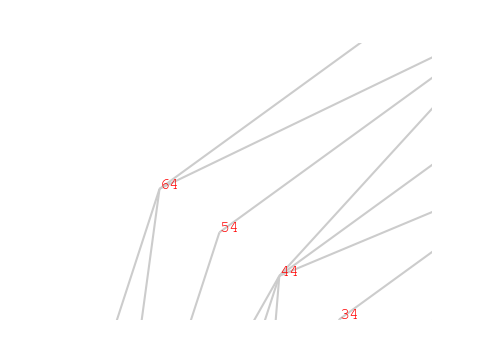

In [307]:
%matplotlib notebook
%config InlineBackend.figure_formats = ['svg']
LS.show()

In [127]:
s = 2
try:
    2+s
except:
    NameError: s+' is not defined'

In [ ]:
def do_shapeME(self, coord, ii):
    
    def shape_(self,r):
        return np.zeros([1,3])     
    def shape_sphere(self,r, TOT_angleX = 2*math.pi, TOT_angleY = math.pi, Ri=3.0,):
        fract_angleX = float((float(self.I[0]*(self.n_L[0]-1)+ii[r,0]))/(self.n_G[0]*(self.n_L[0]-1)))
        fract_angleY = float((float(self.I[1]*(self.n_L[1]-1)+ii[r,1]))/(self.n_G[1]*(self.n_L[1]-1)))
        xt = (z+Ri)*math.cos(TOT_angleX*fract_angleX)*math.sin(TOT_angleY*fract_angleY)-x
        yt = (z+Ri)*math.cos(TOT_angleY*fract_angleY)-y
        zt = (z+Ri)*math.sin(TOT_angleX*fract_angleX)*math.sin(TOT_angleY*fract_angleY)-z
        return np.array([xt,yt,zt]) 
    r = -1
    for x,y,z in coord:
        r = r+1
        coord[r,:] = eval('shape_'+str(self.shape)+'(self,r)')
        flag = False
        for n in self.dim:
            if (self.I[n] == 0)&(ii[r,n] == 0):
                self.Boundary[2*n].append(self.num_r[r])
                self.bound[n].append(self.num_r[r])
            elif (self.I[n] == (n_G[n]-1))&(ii[r,n] == n_L[n]-1)&(flag==False):
                for symmetric in self.bound[n]:
                    if np.all(coord[r,:]==self.mesh[symmetric,:]):
                        self.num_r[r] == symmetric
                        flag = True
                if flag == False:
                    self.Boundary[2*n+1].append(self.num_r[r])
    return coord

In [ ]:
class fregida:
    def __init__(self,t):
        self.no = '0' + str(t)
class patata:

    def __init__(self,_fregida):
        assert type(_fregida)==fregida, 'please'
        self.fregida = _fregida

f = fregida(2)
p = patata(f)
p.fregida.no

def paella(self):
    return self.no +'3'

paella(p.fregida)

In [ ]:
class LatticeStructure:
    def __init__(self, _RVE, n_G, shape=''):
        self.n_G = n_G
        self.shape = shape
        assert type(_RVE) == RVE, 'Please enter an RVE object'
        self.RVE = _RVE
        
    def check_dimensions(self):
        for dimension in [0,1,2]:
            if dimension not in self.RVE.dim:
                self.n_G[dimension] = 1



In [60]:
np.round(np.array([[-4.4408921e-16],[3.3]]), 15)

array([[-0. ],
       [ 3.3]])

In [ ]:
def get_faces(N, t, sizeXYZ, coord, edges, faces=[], show = False):
#    print('get_faces(N, t, sizeXYZ, coord, edges, faces=[], centres=[], show = False F) // newcoord, faces, edges, N, bound_node G')
    
#        # prepare the visualization
#        
#        newcoord = np.asarray(newcoord)
#        N = len(newcoord)
    else:
        bound_node = set()
        newface=[[]]
    return coord, edges, np.asarray(newface),  N, bound_node


In [ ]:




def gen_mesh2D(faces, delta, ii, n_L):
#    print('gen_mesh2D(faces, delta, ii, n_L F) // tri_faces G')
    # Initialize new_faces:
    tri_faces = []
    x,z=np.meshgrid(delta[0],delta[2])
    x = x.flatten()
    z = z.flatten()
    #define 2D points, asx
    #input data for the Delaunay triangulation of U
    tri = Delaunay(np.vstack([x,z]).T)#triangulate the rectangle U
   
    for face in faces:
        index_L = ii[0][face] + ii[2][face]*n_L[0]
        for row in tri.simplices:
            if any(row) not in index_L:    
                pass
            else:
                tri_faces.append(tri.simplices)
    return tri_faces




In [ ]:
###BOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

def do_shapeME(self, coord, ii):
    self._fract_angleX, self._fract_angleX = None, None
    def shape_(self,r):
        return np.zeros([1,3])
       
    def shape_random(self,r, coef_rand =0.625):
        return np.random.uniform(-self.delmax/coef_rand,self.delmax/self.coef_rand,(1,3))
           
    def shape_progressive(self,r):
        try:
            return np.array([float((self.I[0]+ii[r,0])**2), float((self.I[1]+ii[r,1])**2),  float((self.I[2]+ii[r,2])**2)])
        except:
            try:
                return np.array([float((self.I[0]+ii[r,0])**2), 0.0,  float((self.I[2]+ii[r,2])**2)])
            except:
                return np.array([float((self.I[0]+ii[r,0])**2),0.0,0.0])
           
    def shape_flower(self,r, a = 5.0, b = 0.3):
        self.TOT_angleX, self.TOT_angleY = 5*math.pi, 1.0
        xt = (a+z)*math.cos(self.TOT_angleX*self._fract_angleX)*math.sin(self.TOT_angleY*self._fract_angleY)-x
        yt = (a+z)*math.sin(self.TOT_angleX*self._fract_angleX)*math.sin(self.TOT_angleY*self._fract_angleY)-y
        zt = (a+z)*(math.cos(self.TOT_angleY*self._fract_angleY)+math.log(math.tan(0.5*self.TOT_angleY*self._fract_angleY)))+b*self.TOT_angleX*self._fract_angleX-z
        return np.array([xt,yt,zt])
           
    def shape_ring(self,r, R = 25.0, Ri = 3.0):
        self.TOT_angleX, self.TOT_angleY = 2.0*math.pi, 2.0*math.pi
        xt = math.cos(self.TOT_angleX*self._fract_angleX)*(R+(Ri+z)*math.cos(self.TOT_angleY*self._fract_angleY))-x
        yt = math.sin(self.TOT_angleX*self._fract_angleX)*(R+(Ri+z)*math.cos(self.TOT_angleY*self._fract_angleY))-y
        zt = (Ri+z)*math.sin(self.TOT_angleY*self._fract_angleY)-z
        return np.array([xt,yt,zt])
           
    def shape_galaxy(self,r,aa= 3, a=1):
        self.TOT_angleX, self.TOT_angleY = 2*math.pi,4*math.pi
        xt = (a+z)*(aa+math.cos(self.TOT_angleY*self._fract_angleY/2)*math.sin(self.TOT_angleX*
                self._fract_angleX)-math.sin(self.TOT_angleY*self._fract_angleY/2)*math.sin(2*
                                     self.TOT_angleX*self._fract_angleX))*math.cos(self.TOT_angleY*self._fract_angleY) - x
        yt = (a+z)*(aa+math.cos(self.TOT_angleY*self._fract_angleY/2)*math.sin(self.TOT_angleX*
                self._fract_angleX)-math.sin(self.TOT_angleY*self._fract_angleY/2)*math.sin(2*
                                     self.TOT_angleX*self._fract_angleX))*math.sin(self.TOT_angleY*self._fract_angleY) -y
        zt = (a+z)*(math.sin(self.TOT_angleY*self._fract_angleY/2)*math.sin(self.TOT_angleX*
                     self._fract_angleX)+math.cos(self.TOT_angleY*self._fract_angleY/2)*
                     math.sin(2*self.TOT_angleX*self._fract_angleX)) -  z
        return np.array([xt,yt,zt])
           
    def shape_triplefris(self,r):
        self.TOT_angleX, self.TOT_angleY = math.pi, 3*math.pi
        xt = (1+z)*((math.cos(self.TOT_angleX*self._fract_angleX)*((1/3)*math.sqrt(2.0)*
                      math.cos(self.TOT_angleX*self._fract_angleX)*math.cos(2*self.TOT_angleY*self._fract_angleY) + (2/3)*
                      math.sin(self.TOT_angleX*self._fract_angleX)*math.cos(self.TOT_angleY*self._fract_angleY)))/(1 - math.sqrt(2.0)*
                      math.sin(self.TOT_angleX*self._fract_angleX)*math.cos(self.TOT_angleX*self._fract_angleX)*
                      math.sin(3*self.TOT_angleY*self._fract_angleY))) - x
        yt = (1+z)*((math.cos(self.TOT_angleX*self._fract_angleX)*((1/3)*math.sqrt(2.0)*math.cos(self.TOT_angleX*
                      self._fract_angleX)*math.sin(2*self.TOT_angleY*self._fract_angleY) -(2/3)*
                      math.sin(self.TOT_angleX*self._fract_angleX)*math.cos(self.TOT_angleY*self._fract_angleY)))/ (1 - math.sqrt(2.0)*
                      math.sin(self.TOT_angleX*self._fract_angleX)*math.cos(self.TOT_angleX*self._fract_angleX)*
                      math.sin(3*self.TOT_angleY*self._fract_angleY))) - y
        zt = (1+z)*((math.cos(self.TOT_angleX*self._fract_angleX)*math.cos(self.TOT_angleX*self._fract_angleX))/(1 - math.sqrt(2.0)*
              math.sin(self.TOT_angleX*self._fract_angleX)*math.cos(self.TOT_angleX*self._fract_angleX)*math.sin(3*
                      self.TOT_angleY*self._fract_angleY)) - 1) - z
        return np.array([xt,yt,zt])
           
    def shape_quadratic(self,r):
        xt = -0.5*x
        yt = 0
        zt = (0.005*(x-5)**2)
        return np.array([xt,yt,zt])
           
    def shape_shell(self,r):
        xt = 0
        yt = 0
        zt = (0.05*(x-self.delmax[0]*(self.n_G[0]*(self.n_L[0]-1))/2.0)**2) + (0.05*(y-self.delmax[1]*(self.n_G[1]*(self.n_L[1]-1))/2.0)**2)  
        return np.array([xt,yt,zt])
    
    def shape_circle(self,r, Ri = 3.0):
        self.TOT_angleX = 2*math.pi
        return shape_cylinder(self,r)
    
    def shape_cylinder(self,r,Ri = 3.0): 
        self.TOT_angleX = 2*math.pi
        xt = (z+Ri)*math.cos(self._fract_angleX*self.TOT_angleX)-x
        yt = 0
        zt = (z+Ri)*math.sin(self._fract_angleX*self.TOT_angleX)-z
        return np.array([xt,yt,zt])
               
    def shape_catenoid(self,r,Ri = 5.0):
        self.TOT_angleX, self.TOT_angleY = 2*math.pi, math.pi
        xt = (z+Ri)*math.cos(self.TOT_angleX*self._fract_angleX-math.pi)*math.cosh(self.TOT_angleY*self._fract_angleY/Ri)-x
        yt = (z+Ri)*math.sin(self.TOT_angleX*self._fract_angleX-math.pi)*math.cosh(self.TOT_angleY*self._fract_angleY/Ri)-y
        zt = (self.TOT_angleY*self._fract_angleY)-z
        return np.array([xt,yt,zt])
#            
    def shape_sphere(self, r, Ri=3.0):
        self.TOT_angleX, self.TOT_angleY = math.pi, 10.0
        breakpoint()
        xt = (z+Ri)*math.cos(self.TOT_angleX*self._fract_angleX)*math.sin(self.TOT_angleY*self._fract_angleY)-x
        yt = (z+Ri)*math.cos(self.TOT_angleY*self._fract_angleY)-y
        zt = (z+Ri)*math.sin(self.TOT_angleX*self._fract_angleX)*math.sin(self.TOT_angleY*self._fract_angleY)-z
        return np.array([xt,yt,zt])
           
    def shape_NURBS(self,r):
        xt = 0
        yt = 0
        zt = (0.005*(x-self.delmax[0]*(self.n_G[0]*(self.n_L[0]-1))/2.0)*(y-self.delmax[1]*(self.n_G[1]*(self.n_L[1]-1))/2.0))**3
        +(0.005*(x-self.delmax[0]*(self.n_G[0]*(self.n_L[0]-1))/2.0)*(y-self.delmax[1]*(self.n_G[1]*(self.n_L[1]-1))/2.0))**2
        +(0.005*(x-self.delmax[0]*(self.n_G[0]*(self.n_L[0]-1))/2.0)*(y-self.delmax[1]*(self.n_G[1]*(self.n_L[1]-1))/2.0))
        return np.array([xt,yt,zt])
   
    r = -1
    for x,y,z in coord:
        r = r+1
        self._fract_angleX = float((float(self.I[0]*(self.n_L[0]-1)+ii[r,0]))/(self.n_G[0]*(self.n_L[0]-1)))
        self._fract_angleY = float((float(self.I[1]*(self.n_L[1]-1)+ii[r,1])+1)/(self.n_G[1]*(self.n_L[1]-1)))
        self.mesh[self.num_r[0,r]] = coord[r] + eval('shape_'+str(self.shape)+'(self,r)')
        flag = False
        for n in self.RVE.dim:
            if (self.I[n] == 0):

                for symmetric in self.bound[n]:
                    if np.all(np.power(self.mesh[self.num_r[0,r]]-self.mesh[symmetric,:],2)<1e-6)&(flag==False):
                        self.num_r[0,r] = symmetric
                        flag = True
                if (ii[r,n] == 0)&(flag==False):
                    self.Boundary[2*n].add(self.num_r[0,r])
                    self.bound[n].append(self.num_r[0,r])
#                     if (self.TOT_angleX != None): self.bound[n].append(self.num_r[0,r]);print(5) 
            if self.I[n] == (self.n_G[n]-1):
                for symmetric in reversed(self.bound[n]):
                    if np.all(np.power(self.mesh[self.num_r[0,r]]-self.mesh[symmetric,:],2)<1e-6)&(flag==False):
                        self.num_r[0,r] = symmetric
                        flag = True
                if (ii[r,n] == self.n_L[n]-1)&(flag==False):
                    self.Boundary[2*n+1].add(self.num_r[0,r])
                    self.bound[n].append(self.num_r[0,r])
#                     if (self.TOT_angleY != None): self.bound[n].append(self.num_r[0,r]);print(5) 


In [ ]:
def gen_t_faces(index, edges, faces, N, Nold, i = 1):
#    print('gen_t_faces(index, edges, faces, N, n = 0, i = 1 F // index, edges, faces, N + n G)')
    edges.extend([[a] for a in range(Nold, N)])
    face =  [[i-1],[i-1]]
#    facep = [[i-1],[i-1]]
    for irow in [index[1],index[2]]:
        for ii in [0,1]:
            if irow[ii] != -1:
                face[ii].append(irow[ii])
    for f in face:
        ff = f[:]
        if len(f) > 2:
            if f[1] not in edges[f[0]]:
                edges[f[0]].append(f[1])
            edges[f[1]].append(f[2])
            if f[2] not in edges[i]:
                edges[i].append(f[2])
            ff.append(i)
            faces.append(ff)        
    index = index[-2:]
    return index, edges, faces

def gen_thicknes_data(N, coord, t, sizeXYZ, edges):
#    print('gen_t_coord(N, coord, t, sizeXYZ, edges) F // coco, edges, faces, N G')
    coco = []
    ind = []
    faces=[]
    if (0 in edges[np.shape(coord)[0]-1]) or (int(np.shape(coord)[0]-1) in edges[0]):
         c, index, N, Nold = create_points_t(coord[-1],coord[0],coord[1], t, sizeXYZ, N)
         lasti = index[:]
    else:
         c, index, N, Nold = create_points_t(2*coord[0]-coord[1],coord[0],coord[1], t, sizeXYZ, N)
    coco.extend(c)
    ind.extend(index)
    edges.extend([[a] for a in range(Nold, N)])
    for i in range(1,len(coord)-1):
        c, index, N, Nold = create_points_t(coord[i-1],coord[i],coord[i+1], t, sizeXYZ, N)
        coco.extend(c)
        ind.extend(index)
        ind, edges, faces = gen_t_faces(ind, edges, faces, N, Nold, i)
    if (0 in edges[np.shape(coord)[0]-1]) or (int(np.shape(coord)[0]-1) in edges[0]):
        c, index, N, Nold = create_points_t(coord[i],coord[i+1], coord[0], t, sizeXYZ, N)      
        coco.extend(c)
        ind.extend(index)
        ind, edges, faces = gen_t_faces(ind, edges, faces, N, Nold, i+1)
        ind.extend(lasti)
        ind, edges, faces = gen_t_faces(ind, edges, faces, N, Nold, i+2)
    else:
        c, index, N, Nold = create_points_t(coord[i],coord[i+1], 2*coord[i+1]-coord[i], t, sizeXYZ, N)
        coco.extend(c)
        ind.extend(index)
        ind, edges, faces = gen_t_faces(ind, edges, faces, N, Nold, i+1)
    coord = np.concatenate((coord, np.reshape(np.asarray(coco),(len(coco),3))))
    return coord, edges, faces, N
   

def gen_faces(num, ind_hash, faces):
#    print('gen_faces(num, ind_hash, faces F) // faces_i G')
    if np.size(faces) != 0:
        # Initializing global face list
        faces_i =  []
        for num_r in num:
            for face in faces:
                nf = num_r[:,face].tolist()[0]
                nnf = []
                for n in nf:
                    nnf.append(ind_hash[n])
                faces_i.append(nnf)
    else:
        faces_i = faces
    return faces_i


In [ ]:


def create_points_t(c0,c1,c2, T, sizeXYZ, N):
#    print('  create_points_t(c0,c1,c2, T, sizeXYZ F // newp, index, N G')
    Nold = N
    index = []
    newp = []
    np.seterr(divide='ignore')
    t_v = np.array([[(c1[2]-c0[2]),0.0,-(c1[0]-c0[0])],
                     [-(c1[2]-c0[2]),0.0,(c1[0]-c0[0])]])
    t_v = c1 + t_v*(T/(2.0*modeV(t_v[0])))  # point left and point right l01
   
    t_vt = np.array([[(c2[2]-c1[2]),0.0,-(c2[0]-c1[0])],
                     [-(c2[2]-c1[2]),0.0,(c2[0]-c1[0])]])
    t_vt = c1 + t_vt*(T/(2.0*modeV(t_vt[0]))) #  point left and point right l12  
    deltaX = [(c1[0]-c0[0]) == 0.0 , (c2[0]-c1[0]) == 0.0]
    index = np.ones((2,2),dtype=int)*-1
    if all(deltaX):
        point = np.array([c1 + np.sign((c1[2]-c0[2]))*np.array([T/2,0.0,0.0]), c1+ np.sign(-(c1[2]-c0[2]))*np.array([T/2,0.0,0.0])])
        i = -1
        for p in point:
            i = i+1
            if not(any(check_out_bound(p, sizeXYZ, False))):
                index[:,i]=[N,N]
                newp.append(p)
                N = N + 1
    elif any(deltaX):
        for i in range(len(t_v)):
            if deltaX[0]:
                t = [t_v[i], t_vt[i]]
                mm = np.array([(c2[2]-c1[2])/(c2[0]-c1[0])])
                point = np.array(intersect_lines(mm[0], -t[1][0]*mm[0]+t[1][2], mm[0]-1, (t[0][0]-t[1][0]*mm[0]+t[1][2])))
                if not(any(check_out_bound(point, sizeXYZ, False))):
                    index[:,i]=[N,N]
                    newp.append(point)
                    N = N + 1
                else:
                    point = []
                    point.append(intersect_lines(mm[0], -t[1][0]*mm[0]+t[1][2], mm[0]-1, (c1[0]-t[1][0]*mm[0]+t[1][2])))
                    point.append(intersect_lines(mm[0], -t[1][0]*mm[0]+t[1][2], 0.0, c1[2]))
                    for p in point:
                        if not(any(check_out_bound(p, sizeXYZ, equal= False))):
                            index[1,i] = N
                            newp.append(p)
                            N = N+1
            elif deltaX[1]:
                t = [t_v[i], t_vt[i]]
                mm = np.array([(c1[2]-c0[2])/(c2[0]-c0[0])])
                point = np.array(intersect_lines(mm[0], -t[0][0]*mm[0]+t[0][2], mm[0]-1, (t[1][0]-t[0][0]*mm[0]+t[0][2])))
                if not(any(check_out_bound(point, sizeXYZ, False))):
                    index[:,i]=[N,N]
                    newp.append(point)
                    N = N + 1
                else:
                    point = [intersect_lines(mm[0], -t[0][0]*mm[0]+t[0][2], mm[0]-1, (c1[0]-t[0][0]*mm[0]+t[0][2])),
                            intersect_lines(mm[0], -t[0][0]*mm[0]+t[0][2], 0.0, c1[2])]
                    for p in point:
                        if not(any(check_out_bound(p, sizeXYZ, equal= False))):
                            index[0,i] = N
                            newp.append(p)
                            N = N+1
    elif (np.array([t_v[i] == t_vt[i] for i in range(len(t_v))]).all()):
        if ((c1[2]-c0[2]) == 0.0):
            point = np.array([c1 + np.sign((c1[0]-c0[0]))*np.array([0.0,0.0,-T/2]), c1+ np.sign(-(c1[0]-c0[0]))*np.array([0.0,0.0,-T/2])])
            i = -1
            for p in point:
                i = i+1
                if not(any(check_out_bound(p, sizeXYZ, False))):
                    index[:,i]=[N,N]
                    newp.append(p)
                    N = N + 1
        else:
            mm = (c1[2]-c0[2])/(c1[0]-c0[0])
            for i in range(len(t_v)):
                point = t_v[i]
                t = t_v[i]
                if not(any(check_out_bound(point, sizeXYZ, False))):
                    index[:,i]=[N,N]
                    newp.append(point)
                    N = N + 1
                else:
                    point = []
                    try:
                        point.append(intersect_lines(mm, -t[0]*mm+t[2], mm-1, (c1[0]-t[0]*mm+t[2])))
                    except:
                        pass
                    try:
                        point.append(intersect_lines(mm, -t[0]*mm+t[2], 0.0, c1[2]))
                    except:
                        pass
                    for p in point:
                        if not(any(check_out_bound(p, sizeXYZ, equal= False))):
                            index[:,i]= [N,N]
                            newp.append(p)
                            N = N + 1
               
    else:
        mm = np.array([(c1[2]-c0[2])/(c1[0]-c0[0]), (c2[2]-c1[2])/(c2[0]-c1[0])])
        beta = (np.sum(mm))/2
        for i in range(len(t_v)):
            t = [t_v[i], t_vt[i]]
            point = np.array(intersect_lines(mm[0], -t[0][0]*mm[0]+t[0][2], mm[1], -t[1][0]*mm[1]+t[1][2]))
            if not(any(check_out_bound(point, sizeXYZ, False))):
                index[:,i]=[N,N]
                newp.append(point)
                N = N + 1
            elif mm[0] == mm[1]:
                point = []
                try:
                    point.append(intersect_lines(mm[0], -t[0][0]*mm[0]+t[0][2], mm[0]-1, (c1[0]-t[0][0]*mm[0]+t[0][2])))
                except:
                    pass
                try:
                    point.append(intersect_lines(mm[0], -t[0][0]*mm[0]+t[0][2], 0.0, c1[2]))
                except:
                    pass
                for p in point:
                    if not(any(check_out_bound(p, sizeXYZ, equal= False))):
                        index[:,i]= [N,N]
                        newp.append(p)
                        N = N + 1
            else:
                for j in [0,1]:
                    point = []
                    try:
                        point.append(intersect_lines(mm[j], -t[j][0]*mm[j]+t[j][2], mm[j]-1, (c1[0]-t[j][0]*mm[j]+t[j][2])))
                    except:
                        pass
                    try:
                        point.append(intersect_lines(mm[j], -t[j][0]*mm[j]+t[j][2], 0.0, c1[2]))
                    except:
                        pass
                    for p in point:
                        if not(any(check_out_bound(p, sizeXYZ, equal= False))):
                            if mm[0] == mm[1]:
                                index[:,i]= [N,N]
                                j = 2
                            else:
                                index[j,i]= N
                            newp.append(p)
                            N = N + 1    
    return newp, index, N, Nold

In [ ]:
def do_intersect(m1,n1,m2,n2):
#    print('do_intersect(m1, n1, m2, n2 F) // np.array([x, 0.0, x*m1+n1]) G')
    x = (n2-n1)/(m1-m2)
    return np.array([x, 0.0, x*m1+n1])

def gen_points_t(c0,c1,c2,T,sizeXYZ):  
#    print('gen_points_t(c0,c1,c2,T,sizeXYZ F) // newp, N G')
    N = 0
    newp =[]
    try:
        m01 = (c1[2]-c0[2])/(c1[0]-c0[0])
        m12 = (c2[2]-c1[2])/(c2[0]-c1[0])
        if m01 == 0 and m12 == 0:
            if bool(c1[2]):
                newp.append(c1-np.array([0,0,T/2]))
                N = N + 1
            if bool(c1[2]-sizeXYZ[2]):
                newp.append(c1+np.array([0,0,T/2]))
                N = N + 1
        else:
            t_v = np.array([[(c1[2]-c0[2]),0.0,-(c1[0]-c0[0])],
                             [-(c1[2]-c0[2]),0.0,(c1[0]-c0[0])]])
            t_v = c1 + t_v*(T/(2.0*do_modeV(t_v[0]))) # point left and point right
            beta = (m01+m12)/2 # mean slope betweem
            if ((c1[0] == 0.0) or (c1[0] == sizeXYZ[0])) and ((c1[2] == 0.0) or (c1[2] == sizeXYZ[2])):
                for i in range(len(t_v)):
                    t = t_v[i]
                    N = N +1
                    if t[0] < 0.0 or t[0]> sizeXYZ[0]:
                        newp.append(do_intersect(m01, -t[0]*m01+t[2], m01-1, (c1[0]-t[0]*m01+t[2])))
                    if t[2] < 0.0 or t[2]> sizeXYZ[2]:  
                        newp.append(do_intersect(m01, -t[0]*m01+t[2], 0.0, c1[2]))
            elif (c1[0] == 0.0) or (c1[0] == sizeXYZ[0]):
                for i in range(len(t_v)):
                    t = t_v[i]
                    if t[0] < 0.0 or t[0] > sizeXYZ[0]:
                        N = N + 2
                        tt = np.array([[(c2[2]-c1[2]),0.0,-(c2[0]-c1[0])],
                                         [-(c2[2]-c1[2]),0.0,(c2[0]-c1[0])]])[i]
                        tt = c1 + tt*(T/(2.0*do_modeV(tt)))
                        newp.append([do_intersect(m01, -t[0]*m01+t[2], m01-1, (c1[0]-t[0]*m01+t[2])),
                         do_intersect(m12,-tt[0]*m12+tt[2], m12-1, (c1[0]-tt[0]*m12+tt[2]))])
                    else:
                        N = N +1
                        newp.append(do_intersect(m01, -t[0]*m01+t[2], beta, -c1[0]*beta + c1[2]))
            elif (c1[2] == 0.0) or (c1[2] == sizeXYZ[2]):
                for i in range(len(t_v)):
                    t = t_v[i]
                    if t[2] < 0.0 or t[2] > sizeXYZ[2]:
                        N = N + 2
                        tt = np.array([[(c2[2]-c1[2]),0.0,-(c2[0]-c1[0])],
                                         [-(c2[2]-c1[2]),0.0,(c2[0]-c1[0])]])[i]
                        tt = c1 + tt*(T/(2.0*do_modeV(tt)))
                        newp.append([do_intersect(m01, -t[0]*m01+t[2], 0.0, c1[2]),
                                     do_intersect(m12,-tt[0]*m12+tt[2], 0.0, c1[2])])
                    else:
                        N = N + 1
                        newp.append(do_intersect(m01, -t[0]*m01+t[2], beta, -c1[0]*beta + c1[2]))
            else:
                for i in range(len(t_v)):
                    N = N + 1
                    t = t_v[i]
                    newp.append(do_intersect(m01, -t[0]*m01+t[2], beta, -c1[0]*beta + c1[2]))
    except:
        if bool(c1[0]):
            newp.append(c1-np.array([T/2,0,0]))
            N = N +1
        if bool(c1[0]-sizeXYZ[0]):
            N = N + 1
            newp.append(c1+np.array([T/2,0,0]))
    return newp, N

def gen_thickness_data(N, coord, t, sizeXYZ, edges):
#    print('gen_thickness_data(N, coord, t, sizeXYZ, edges F) // coco, edges, N + n G')
    coco = []
    c, n = gen_points_t(2*coord[0]-coord[1],coord[0],coord[1], t, sizeXYZ)
    coco.extend(c)
    edges.extend([[a] for a in range(N, N + n)])
    edges[0].extend(list(range(N, N + n)))
    N = N + n
    for i in range(1,len(coord)-1):
        c, n = gen_points_t(coord[i-1],coord[i],coord[i+1], t, sizeXYZ)
        coco.extend(c)
        edges.extend([[a] for a in range(N, N + n)])
        edges[i].extend(list(range(N, N + n)))
        N = n + N
    c, n = gen_points_t(coord[i],coord[i+1], 2*coord[i+1]-coord[i], t, sizeXYZ)
    coco.extend(c)
    edges.extend([[a] for a in range(N, N + n)])
    edges[i+1].extend(list(range(N, N + n)))
    return coco, edges, N + n


In [ ]:


def do_scale(coord, scale):
#    print(' do_scale( coord, scale F) // scaled_coord G')
    if type(coord) == list:
        coord = np.asanyarray(coord)
    max_coord = np.max(coord, axis=0)
    scaled_coord = np.multiply(np.divide(coord,max_coord), scale)
    return scaled_coord

   
def do_translate(tobetranslated, dictionary):
    if type(tobetranslated) == list:
        translation=[]
        word_o = -1
        for word in tobetranslated:
            if word == word_o:
                pass
            else:
                try:
                    translation.append(dictionary[word])
                except:
                    pass
            word_o = word
#    print('do_translate(tobetranslated, dictionary F) // translation G')
    return translation


In [ ]:
def check_boundary(num, mesh, p, index, ii, i, j, k, n_L, LS, Boundary, shape, dim, delmax):
#    print('check_boundary(num_r, mesh_r, ii, i, j, k, n_L, LS.n_G, delmax, Boundary, shape, dim F) // Boundary G')
#    
#    if (i == 0 or LS.n_G[0]) and (j ==0 or LS.n_G[1]) and (k ==0 or LS.n_G[2]):
#        for i in dim:
#            b0 = (num_r[abs(mesh_r[num_r,i] - do_shapeME(np.zeros([1,3]), n_L, LS.n_G, delmax, shape, ii)[0,i])<= 10**-7])
#            for b in b0:
##                flag = True
#                if b not in Boundary[(i*2)]:
#                    Boundary[(i*2)].append(b)
##                    flag = False
#            b1 = (num_r[abs(mesh_r[num_r,i] - np.multiply(LS.n_G, delmax)[i] - do_shapeME(np.array([np.multiply(LS.n_G, delmax)]),
#                        n_L, LS.n_G, delmax, shape, ii)[0,i])<=10**-7])
##            if b1
#            for b in b1:
#                if b not in Boundary[(i*2+1)]:
#                    Boundary[(i*2+1)].append(b)
#                  
                       
#    if 1 not in dim:
#        Boundary=[Boundary[0],Boundary[1],[],[],Boundary[4],Boundary[5]]
#    return Boundary
#    num_r = [n for n in num_r[0]]
    dix=[i,j,k]
    ii=np.reshape(np.asarray(ii),(len(ii),3))
    iimax=np.max(ii, axis=0)
    num_r=num[p,:].astype("int")
    for d in dim:
        b0 = num_r[ii[:,d]==0].tolist()
        b1 = num_r[ii[:,d]==iimax[d]].tolist()
        if dix[d] == 0:
            for b in b0:
                if b not in Boundary[(d*2)]:
                    Boundary[2*d].append(b)
        if dix[d] == (LS.n_G[d]-1):
            kk = 1
            symb=Boundary[2*d]
            for b in b1:
                for s in symb:
                    if all(abs(mesh[b,:]-mesh[s,:])**2 <10e-4):
                        index[b]=0
                        num_r[num_r==b]=s
                        b = s
                        kk = kk+1
                if b not in Boundary[(d*2+1)]:              
                    Boundary[2*d+1].append(b)

    return Boundary, num_r, index


In [ ]:
def gen_edges(num, ind_hash, edges):
#    print('gen_edges(num, ind_hash, edges F) // edges_i G')
    # Initializing global adjecency list
    edges_i =  [[a] for a in range(len(ind_hash))]
    #consider only the lower triangle of the symetric matrix
    Nedges = 0
    for row in np.array(num):
        i = -1
        for node_in in row:
            i = i + 1
            node_con = row[edges[i]]
            node_in = ind_hash[node_in]
            for node_out in node_con[1:]:
                node_out = ind_hash[node_out]
                if (node_out not in edges_i[node_in])and(node_in not in edges_i[node_out]):
                    edges_i[node_in].append(node_out)
                    Nedges = Nedges + 1
    return edges_i, Nedges

In [ ]:

def gen_CAD(filename, dim, mesh, lim, edges_i, faces_i, t, Export, View, foldername = ''):
#    print('gen_CAD(filename, dim, mesh, lim, edges_i, faces_i, t, Export, View, foldername = '' F)')
    if (Export or View):
        low, high = iter(lim)
#    dim=[0,1,2]
        parent_folder = os.getcwd()
        try:
            openFolder(foldername)
        except:
            pass
            # Initializing file
       
        elif Export:
            try:
                os.remove(filename+'.dxf' )
                print("drawing '%s.dxf' replaced.\n" % filename)
                drawing = dxf.drawing( filename+'.dxf' )
            except:
                print("drawing '%s.dxf' created.\n" % filename)
                drawing = dxf.drawing( filename+'.dxf' )
            for n0 in edges_i:
                for n1 in n0[1:]:
                    drawing.add(dxf.polyline([mesh[n0[0],dim], mesh[n1,dim]], layer = 'edges', startwidth =t, endwidth= t))
            drawing.save()
            if np.shape(faces_i)[1] != 0:
                drawing = dxf.drawing( filename+'f'+'.dxf' )
                for face in faces_i:
                    f=[]
                    for i in range(len(face)):
                        f.append(tuple(mesh[face[i],dim]))
                    f = dxf.face3d(f, flags=1)
                    f['layer'] = 'faces'
                    f['color'] = 7
                    drawing.add(f)
                    del(f)
            drawing.save()
        os.chdir(parent_folder)
    else:
        pass


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, rc

import pandas as pd
#rcParams['font.family'] = 'serif'
#rcParams['font.sans-serif'] = ['serif']
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True


data = pd.read_csv("data.csv",sep=';')
n = np.array(data['n'])
e = np.array(data['e'])	
f = np.array(data['f'])
t = np.array(data['t'])
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True



c:\users\jccap\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  if __name__ == '__main__':
c:\users\jccap\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


<Figure size 640x480 with 1 Axes>

In [2]:

plt.loglog(n,t,'o-r',linewidth=2, markersize=4, label = 'nodes')
plt.loglog(e,t,'o-b',linewidth=2, markersize=4, label = 'edges')
plt.loglog(f,t,'o-g',linewidth=2, markersize=4, label = 'faces')
plt.loglog(np.array([n[0],n[-1]]),np.array([t[0],t[-1]]),linewidth=1,color='grey', label = '1 slope line')
plt.legend()
plt.axis('scaled')
plt.xlabel('number of elements', fontsize = 12)
plt.ylabel('running time [s]', fontsize = 12)
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x288 with 1 Axes>